In [1]:
import torch
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
     

Setup complete. Using torch 2.0.1 _CudaDeviceProperties(name='NVIDIA GeForce GTX 1650 SUPER', major=7, minor=5, total_memory=4095MB, multi_processor_count=20)


In [2]:
from fastai.vision.all import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import cv2
from PIL import Image

In [4]:
train = pd.read_csv(r'E:\My Manat\dd\Train.csv')
print(train.shape)
train.head()

(8512, 2)


,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast


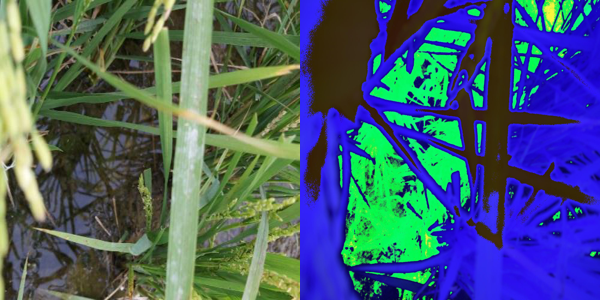

In [5]:
out = Image.new('RGB', (600, 300))
out.paste(Image.open(r'E:\My Manat\dd\images\id_004wknd7qd.jpg').resize((300, 300)), (0, 0))
out.paste(Image.open(r'E:\My Manat\dd\images\id_004wknd7qd_rgn.jpg').resize((300, 300)), (300, 0))
out

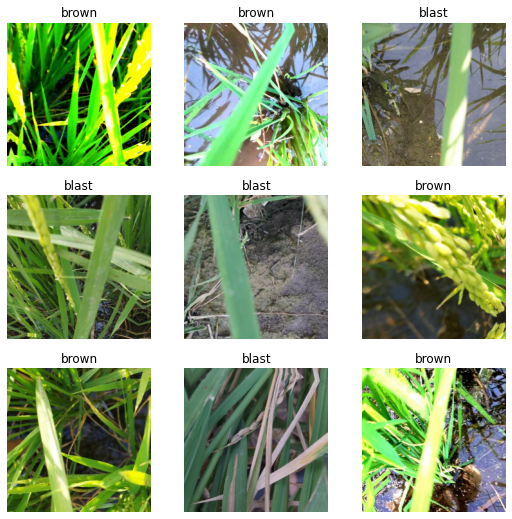

In [6]:
train_rgb = train[~train.Image_id.str.contains('_rgn')] # Just the RGB images
dls = ImageDataLoaders.from_df(train_rgb, fn_col='Image_id', label_col='Label', 
                               folder='E:/My Manat/dd/images', item_tfms=Resize(400),
                               batch_tfms = aug_transforms(size=224))
dls.show_batch() # Note the augmentation applied to the images!

In [7]:
k=list(np.arange(0.0001,1, 0.001))[:3]

In [8]:
learn = vision_learner(dls, resnet18,metrics=[error_rate,accuracy], lr=0.0025)
learn.fine_tune(20)

C:\Users\Ibrahim_Refa3i\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ibrahim_Refa3i\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.232649,0.629026,0.227700,0.772300,02:47


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.776484,0.466888,0.177230,0.822770,00:42
1,0.642979,0.371773,0.142019,0.857981,00:35
2,0.542078,0.323409,0.113850,0.886150,00:35
3,0.425799,0.253229,0.083333,0.916667,00:36
4,0.341283,0.226864,0.084507,0.915493,01:24
5,0.265511,0.201339,0.070423,0.929577,00:59
6,0.203009,0.168676,0.058685,0.941315,00:35
7,0.150677,0.152655,0.050469,0.949531,00:35
8,0.128941,0.148065,0.042254,0.957747,00:36
9,0.115905,0.143964,0.037559,0.962441,00:37


In [9]:
data = (learn.recorder.values)

In [10]:
train_loss=[item[0] for item in data]
val_loss=[item[1] for item in data]
error_rate = [item[2] for item in data]
accuracy = [item[3] for item in data]
epochs = range(1, len(data) + 1)


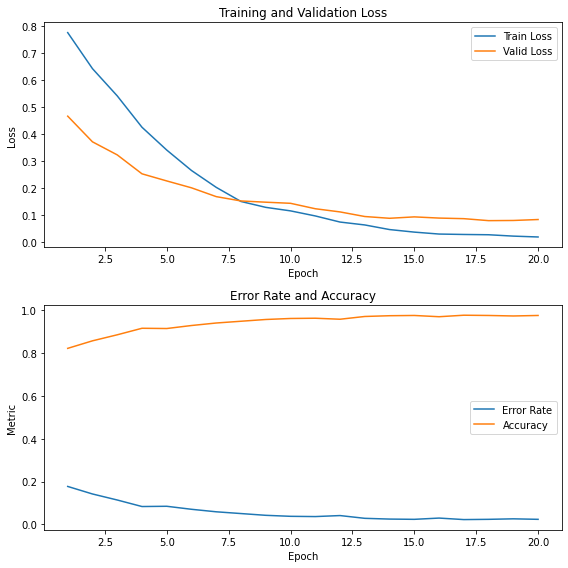

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
# Plotting train_loss and valid_loss in the first subplot
ax1.plot(epochs, train_loss, label='Train Loss')
ax1.plot(epochs, val_loss, label='Valid Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plotting error_rate and accuracy in the second subplot
ax2.plot(epochs, error_rate, label='Error Rate')
ax2.plot(epochs, accuracy, label='Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Metric')
ax2.set_title('Error Rate and Accuracy')
ax2.legend()

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

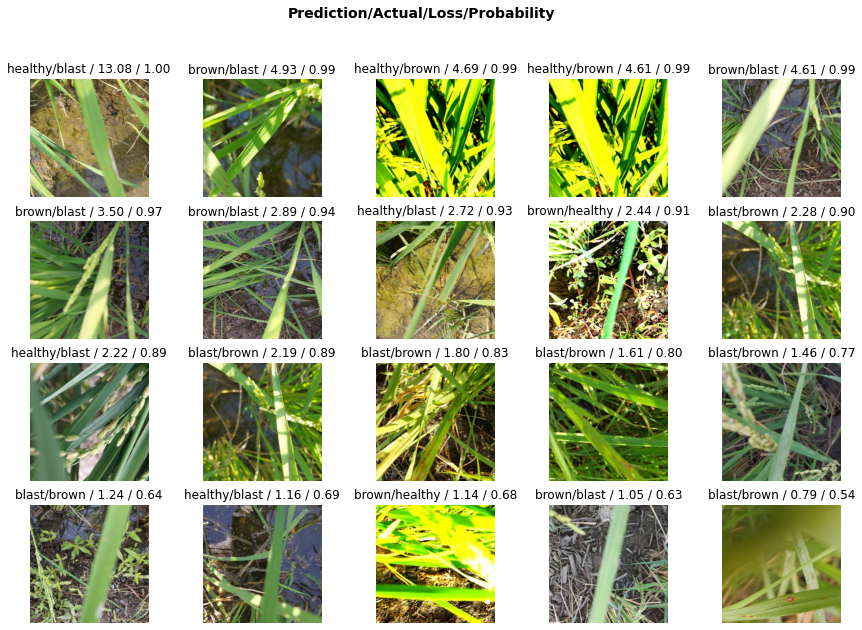

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(20, figsize=(15,10))

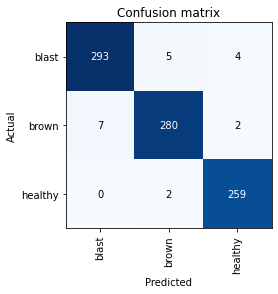

In [14]:
interp.plot_confusion_matrix()

In [15]:
test = pd.read_csv(r'E:\My Manat\dd\Test.csv')
test = test[~test.Image_id.str.contains('_rgn')] # Just the RGB images

In [16]:
preds, _ = learn.get_preds(dl=dls.test_dl(test)) # Getting the predicted probabilities
preds

tensor([[1.0000e+00, 9.6722e-07, 1.4873e-07],
        [9.7236e-04, 9.9902e-01, 1.2155e-05],
        [2.8291e-01, 2.6694e-02, 6.9039e-01],
        ...,
        [9.8778e-01, 1.2206e-02, 1.8417e-05],
        [9.9828e-01, 2.9176e-06, 1.7170e-03],
        [3.6823e-03, 3.2526e-06, 9.9631e-01]])

In [17]:
submission = pd.DataFrame({'Image_id': test['Image_id']})
for i, label in enumerate(learn.dls.vocab):
    submission[label] = preds[:,i].numpy()
submission.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999999,9.672200e-07,1.487337e-07
2,id_01hu05mtch.jpg,0.000972,9.990155e-01,1.215550e-05
4,id_030ln10ewn.jpg,0.282911,2.669440e-02,6.903947e-01
6,id_03z57m8xht.jpg,0.999999,6.040751e-07,8.351959e-09
8,id_04ngep1w4b.jpg,0.999646,3.372661e-04,1.640503e-05


In [24]:
preds, targets = learn.get_preds()

In [25]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming 'preds' and 'targets' are NumPy arrays
# Compute precision
precision = precision_score(targets, preds.argmax(axis=1), average='macro')

preds2 = preds.argmax(axis=1)
targets2 = targets

In [26]:
# Compute the F1 score for each class
f1_scores = f1_score(targets2, preds2, average=None)

# Compute macro-averaged F1 score
macro_f1 = f1_score(targets2, preds2, average='macro')

# Compute micro-averaged F1 score
micro_f1 = f1_score(targets2, preds2, average='micro')

# Print the results
print("Acuuracy :",1-learn.validate()[1])
print("Precision:", precision)
print("F1 Scores:", f1_scores)
print("Macro-F1:", macro_f1)
print("Micro-F1:", micro_f1)

Acuuracy : 0.9765258207917213
Precision: 0.9765449711100884
F1 Scores: [0.97342193 0.97222222 0.98479087]
Macro-F1: 0.9768116745524121
Micro-F1: 0.9765258215962441


In [50]:
model = learn.model
output_path = 'E:/My Manat/dd/my_model.pt'
torch.save(model,output_path)